# Bengali Fake News Classification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.4 MB/s eta 0:00:00


In [ ]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
from sklearn.model_selection import train_test_split

auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Authentic-48K.csv")
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake-1K.csv")
df = auth[:fake.shape[0]* 15]

df = df.append(fake)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])


df = train_df.append(train_df[train_df['label']==0].sample(len(fake)*6, replace=True))
df = df.sample(frac=1).reset_index(drop=True)
len(df) , len(auth)
train_df=df

In [ ]:
len(train_df)

24421

In [ ]:
train_df[train_df['label']==0].head()

,articleID,domain,date,category,headline,content,label
0,64,bengaliviralnews.com,2019-05-26T04:27:49+00:00,Miscellaneous,বাড়িতে যদি এই ৭টি জিনিস থাকে তাহলে আপনার মারা...,বাস্তুসাস্ত্র মতে আমাদের বাড়ির চার দেওয়ালের অ...,0
3,64,bengaliviralnews.com,2019-05-26T04:27:49+00:00,Miscellaneous,বাড়িতে যদি এই ৭টি জিনিস থাকে তাহলে আপনার মারা...,বাস্তুসাস্ত্র মতে আমাদের বাড়ির চার দেওয়ালের অ...,0
6,587,earki.com,"সেম্বর ১১, ২০১৮",Sports,বাংলাদেশ ক্রিকেট দলের পরাজয়ের কারণ বিশ্লেষণ কর...,ক্রিকেটে বাংলাদেশকে ছোট চোখে দেখার দিন গত হয়েছ...,0
8,340,earki.com,"১৯:০৪, ফেব্রুয়ারি ০৭, ২০১৯",Technology,দাওয়াত না পেলেও এখন বিদেশিরা টিকিট কেটে দেখতে ...,ভারতীয় উপমহাদেশে বিয়ে মানেই অনেক দেন-দরবারের প...,0
10,339,bangla24.com.bd,2018-08-12T13:37:55+06:00,Lifestyle,আমার জীবনে পাওয়া সেরা ১০টি লজ্জা !,"ড. মাহফুজুর রহমান: (১) ক্লাস ফাইভে পড়ি, পাশের...",0


In [ ]:
df.head()

,articleID,domain,date,category,headline,content,label
0,64,bengaliviralnews.com,2019-05-26T04:27:49+00:00,Miscellaneous,বাড়িতে যদি এই ৭টি জিনিস থাকে তাহলে আপনার মারা...,বাস্তুসাস্ত্র মতে আমাদের বাড়ির চার দেওয়ালের অ...,0
1,3458,banglanews24.com,2018-09-20 16:58:14,Crime,কুমিল্লায় হত্যা মামলায় খালেদার জামিন শুনানি পে...,কুমিল্লা: কুমিল্লার চৌদ্দগ্রামে বাসে পেট্রোল ব...,1
2,11215,banglanews24.com,2018-09-23 22:23:56,Miscellaneous,উপকূল উন্নয়ন ভাবনার সাংগঠনিক সপ্তাহ শুরু সোমবার,খুলনা: দেশের ঝুঁকিপূর্ণ উপকূলীয় জনগোষ্ঠীর মৌলি...,1
3,64,bengaliviralnews.com,2019-05-26T04:27:49+00:00,Miscellaneous,বাড়িতে যদি এই ৭টি জিনিস থাকে তাহলে আপনার মারা...,বাস্তুসাস্ত্র মতে আমাদের বাড়ির চার দেওয়ালের অ...,0
4,17718,banglanews24.com,2018-09-26 17:22:49,Sports,বিশেষজ্ঞ চিকিৎসক দেখাতে ইংল্যান্ডে যাচ্ছেন তামিম,ঢাকা: এশিয়া কাপে বাঁ হাতের কব্জিতে পাওয়া চোট ...,1


In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        i= ps.stem(i)
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = train_df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


********** Before ***************
কুমিল্লা: কুমিল্লার চৌদ্দগ্রামে বাসে পেট্রোল বোমা হামলায় আটজন হত্যা মামলায় বিএনপি চেয়ারপারসন খালেদা জিয়ার জামিন শুনানি পিছিয়ে ৩০ সেপ্টেম্বর নির্ধারণ করেছেন আদালত। শুনানিতে রাষ্ট্র পক্ষের আইনজীবীদের আবেদনের পরিপ্রেক্ষিতে শুনানি পিছিয়ে দেওয়া হয়। চ্যারিটেবল মামলার শুনানি ২৪ সেপ্টেম্বর পর্যন্ত মুলতবি বৃহস্পতিবার (২০ সেপ্টেম্বর) দুপুরে হত্যা মামলাটির শুনানি শেষে কুমিল্লা সিনিয়র জুডিশিয়াল ম্যাজিস্ট্রেট ৫নং আমলী আদালতের ভারপ্রাপ্ত বিচারক গোলাম মাহবুব খান পরবর্তী শুনানির জন্য আগামী ৩০ সেপ্টেম্বর দিন ধার্য করেন। এ বিষয়টি নিশ্চিত করেন খালেদা জিয়ার আইনজীবী অ্যাডভোকেট কাইমুল হক রিংকু। এর আগে ২০১৫ সালের ৩ ফেব্রুয়ারি ভোরে ২০ দলীয় জোটের অবরোধের সময় চৌদ্দগ্রামের জগমোহনপুরে একটি বাসে পেট্রোল বোমা ছুঁড়ে মারে দুর্বৃত্তরা। এতে আটজন যাত্রী দগ্ধ হয়ে মারা যায় ও আহত হয় ২০ জন। এ ঘটনায় চৌদ্দগ্রাম থানার উপ-পরিদর্শক (এসআই) নুরুজ্জামান বাদী হয়ে ৫৬ জনের নামোল্লেখ করে এবং অজ্ঞাতপরিচয় ১৫/২০ জনের বিরুদ্ধে মামলা দায়ের করেন। এ ঘটনায় খালেদাসহ বিএনপির শীর্ষস্থানীয় ছয়জন নেতার বিরুদ্ধে হত্য

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
train_df['head'] = train_df.headline.apply(clean_text)
train_df['con'] = train_df.content.apply(clean_text)
test_df['head'] = test_df.headline.apply(clean_text)
test_df['con'] = test_df.content.apply(clean_text)

from sklearn.model_selection import train_test_split

train_df, testa_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(df), len(test_df)

(24421, 4157)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [ ]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 256)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)

        # dense layer 2 (Output layer)
        self.fc5 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(self.dropout(x))
        x = self.relu(x)
        x = self.fc4(self.dropout(x))
        x = self.relu(x)

        # output layer
        x = self.fc5(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [ ]:
# for param in bert.parameters():
#     param.requires_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [ ]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[-0.0777,  0.0234]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Training

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 10
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.270184.. 	Valid Loss:0.135880.. 	Accuracy: 97.2817
Epoch: 2/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.054467.. 	Valid Loss:0.202473.. 	Accuracy: 97.4020
Epoch: 3/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.010257.. 	Valid Loss:0.173462.. 	Accuracy: 97.5704
Epoch: 4/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.005022.. 	Valid Loss:0.187063.. 	Accuracy: 97.6906
Epoch: 5/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.002075.. 	Valid Loss:0.188880.. 	Accuracy: 97.5944
Epoch: 6/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.001479.. 	Valid Loss:0.193866.. 	Accuracy: 97.5944
Epoch: 7/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.002438.. 	Valid Loss:0.194237.. 	Accuracy: 97.5944
Epoch: 8/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.001653.. 	Valid Loss:0.195336.. 	Accuracy: 97.6185
Epoch: 9/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.001426.. 	Valid Loss:0.195336.. 	Accuracy: 97.6185
Epoch: 10/10


  0%|          | 0/1527 [00:00<?, ?it/s]

	Train loss:0.001253.. 	Valid Loss:0.195369.. 	Accuracy: 97.6185
Training completed in 109m 12s


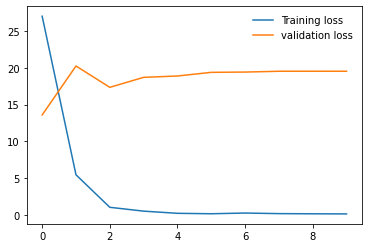

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [ ]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.88      0.65      0.75       260
           1       0.98      0.99      0.99      3897

    accuracy                           0.97      4157
   macro avg       0.93      0.82      0.87      4157
weighted avg       0.97      0.97      0.97      4157



#### Thank you very much for reading.
### পড়ার জন্য আপনাকে অনেক ধন্যবাদ।

In [ ]:
 from sklearn import metrics

In [ ]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_preds)



In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


In [ ]:
import matplotlib.pyplot as plt



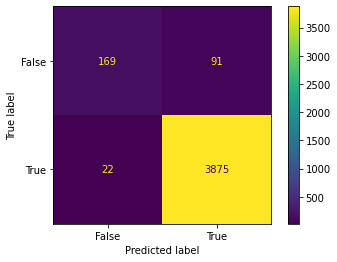

In [ ]:
cm_display.plot()
plt.show()